In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error ,mean_absolute_percentage_error

In [2]:
df = pd.read_csv("Electricity Consumption.csv")

In [3]:
df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [4]:
#Converted Date column to DataTime
df['DATE']= pd.to_datetime(df['DATE'])

In [5]:
#Made the Date column as index 
df.set_index('DATE',inplace = True)

In [6]:
x=df.index.max() - df.index.min()

In [7]:
x=str(x).replace(" days 00:00:00","")
x=int(x)//365
print(f"We have {x} years of previous data")

We have 46 years of previous data


In [8]:
df.isnull().sum()

Electricty_Consumption_in_TW    0
dtype: int64

#### There are no missing values

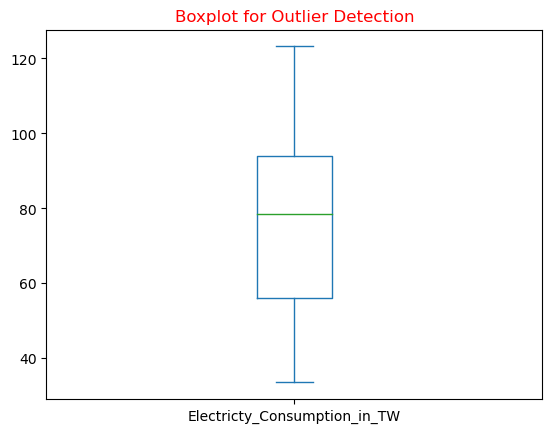

In [9]:
df.plot(kind='box')
plt.title("Boxplot for Outlier Detection",c='r')
plt.show()

#### There are no outliers in the provided data.

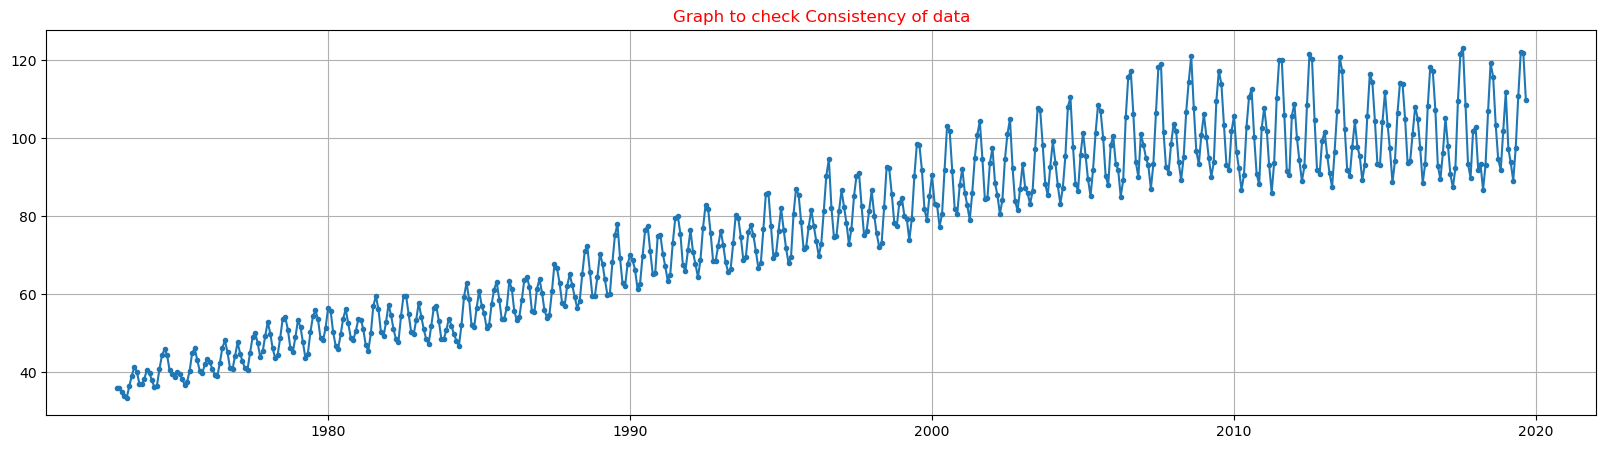

In [10]:
plt.figure(figsize=(20,5))
plt.plot(df, marker  = ".")
plt.title("Graph to check Consistency of data",c='r')
plt.grid()

#### Since the line is not broken we can say that we have consistent data. ????

In [11]:
df.head()

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107


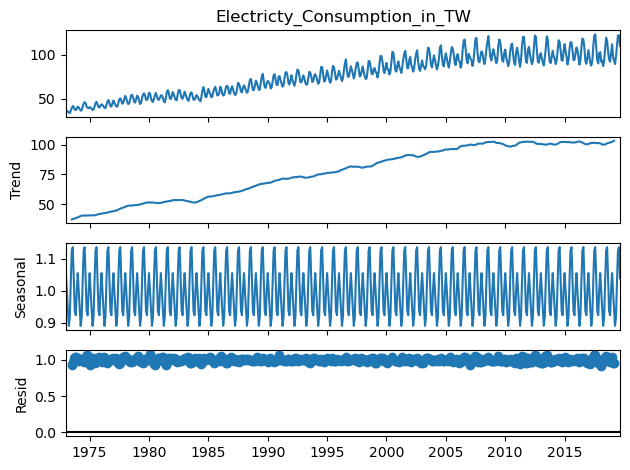

In [14]:
decom = seasonal_decompose(df["Electricty_Consumption_in_TW"],model='multiplicative')
decom.plot()
plt.show()

### Stationarity of the data

In [195]:
def get_adfuller(ts):
    return pd.Series(adfuller(ts)[:4],index = ["Test Statistic", "p-value", "Lags Used", "Number of Observations"])

In [196]:
get_adfuller(df)

Test Statistic             -1.740593
p-value                     0.410328
Lags Used                  15.000000
Number of Observations    545.000000
dtype: float64

####
#### H0 : Data is non-stationary.
#### HA : Data in stationary.
#### p-value in our case is greater than 0.05, therefore we fail to reject the null hypothesis. 

In [197]:
get_adfuller(df.diff().dropna())

Test Statistic           -7.941665e+00
p-value                   3.301344e-12
Lags Used                 1.400000e+01
Number of Observations    5.450000e+02
dtype: float64

#### now p-value in our case is less than 0.05, therefore we reject the null hypothesis.
#### And can conclude that our data is stationary.

In [198]:
df=df.diff()

In [199]:
df.dropna(inplace=True)

In [200]:
df.shape

(560, 1)

In [201]:
560/4

140.0

In [202]:
140*3

420

In [203]:
#Using 3 equal parts of data for training and 1 for testing.
train, test = df[:420], df[420:]

In [204]:
train.shape, test.shape

((420, 1), (140, 1))

In [205]:
#Fitting the model with random p,d,q values
model = ARIMA(train, order = (2, 1, 1 ))
model_fit = model.fit()

In [206]:
preds1 = model_fit.forecast(steps = 140)

In [207]:
mae  = mean_absolute_error(preds1, test)
print(mae)

7.593103998612925


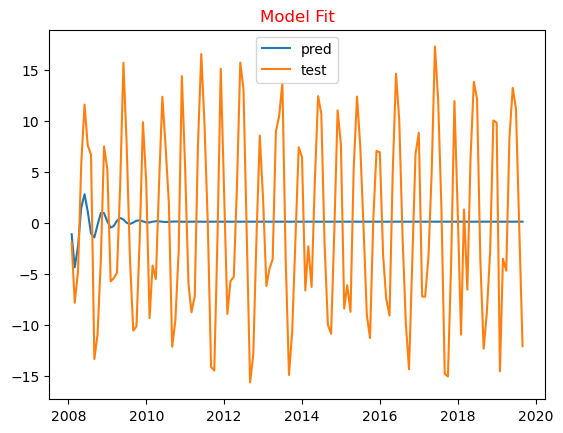

In [208]:
plt.plot(preds1, label = "pred")
plt.plot(preds1.index, test, label = "test")
plt.title("Model Fit",c='r')
plt.legend()
plt.show()

#### From the above plot we can say that with this value of p,d and q ARIMA is not fitting well.

#### Finding value of p,d,q

In [209]:
p_range = range(0, 4)
d_range = range(0, 4)
q_range = range(0, 4)

order_list,mae_list = [], []
for p in p_range:
    for d in d_range:
        for q in q_range:
            order = (p, d, q)
            model = ARIMA(train, order = order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps = 140)
            mae = mean_absolute_error(forecast, test)
            order_list.append(order)
            mae_list.append(mae)

In [210]:
grid=pd.DataFrame(order_list,mae_list).reset_index()

In [211]:
grid.head()

,index,0,1,2
0,7.703055,0,0,0
1,7.699991,0,0,1
2,7.718656,0,0,2
3,7.681476,0,0,3
4,8.682664,0,1,0


In [212]:
grid.rename(columns={'index':"MAE",
                    0:"P",
                    1:'D',
                    2:'Q'},inplace = True)

In [213]:
grid.head()

,MAE,P,D,Q
0,7.703055,0,0,0
1,7.699991,0,0,1
2,7.718656,0,0,2
3,7.681476,0,0,3
4,8.682664,0,1,0


In [214]:
grid.sort_values(by='MAE',ascending=True).head()

,MAE,P,D,Q
51,3.510487,3,0,3
34,3.512348,2,0,2
50,3.514556,3,0,2
35,3.523783,2,0,3
39,3.533855,2,1,3


#### Updated the values of p,d,q 

In [215]:
model = ARIMA(train, order = (3, 0, 3 ))
model_fit = model.fit()

In [216]:
preds2 = model_fit.forecast(steps = 140)

In [217]:
mae  = mean_absolute_error(preds2, test)
print(mae)

3.510486880346227


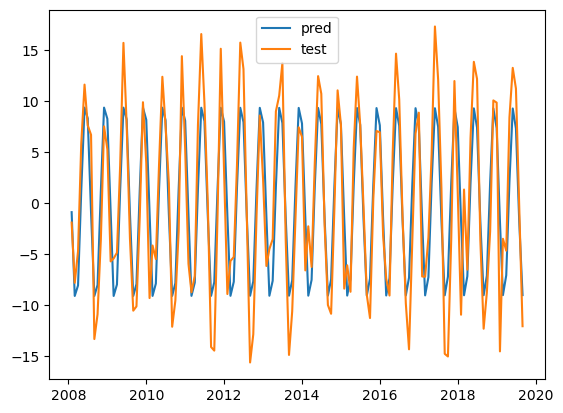

In [218]:
plt.plot(preds2, label = "pred")
plt.plot(preds2.index, test, label = "test")
plt.legend()
plt.show()

### From the above plot of test and train we can say that our model is able to fit the data well.

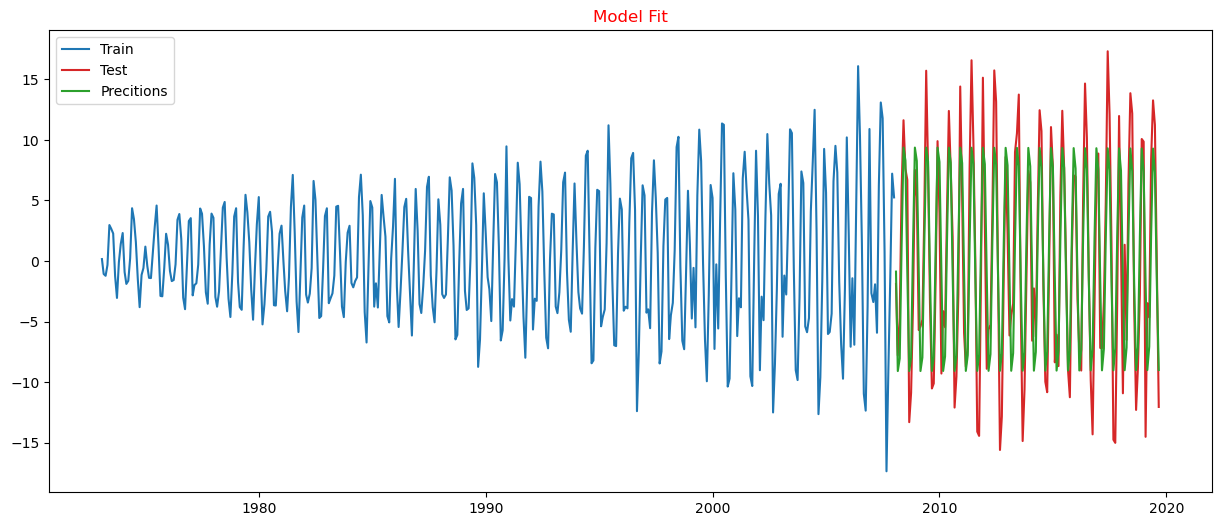

In [219]:
plt.figure(figsize=(15,6))
plt.plot(train,c='#1f77b4',label='Train')
plt.plot(test,c='#d62728',label='Test')
plt.plot(test.index, preds2,c='#2ca02c',label='Precitions')
plt.legend()
plt.title("Model Fit",c='r')
plt.show()

### SARIMA

In [220]:
order = (3,0, 3)  # p, d, q
seasonal_order  = (3, 0, 3, 12) #P, D, Q, T
model = SARIMAX(train, order=order, seasonal_order= seasonal_order)

model_fit = model.fit(disp=False)
preds3 = model_fit.forecast(steps = len(test))

In [221]:
mean_absolute_error(test, preds3)

1.935190551907037

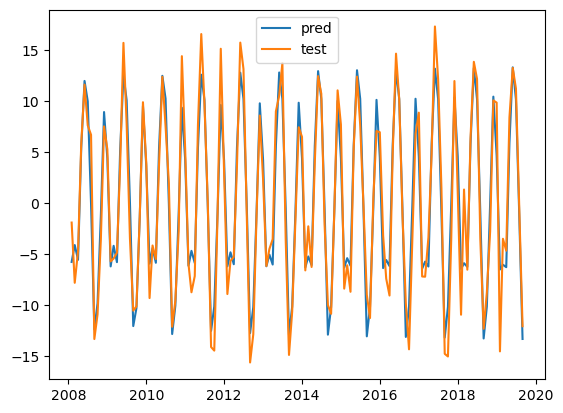

In [222]:
plt.plot(preds3, label = "pred")
plt.plot(preds3.index, test, label = "test")
plt.legend()
plt.show()

#### From the above plot of test and train we can say that our model is able to fit the data in more better way.

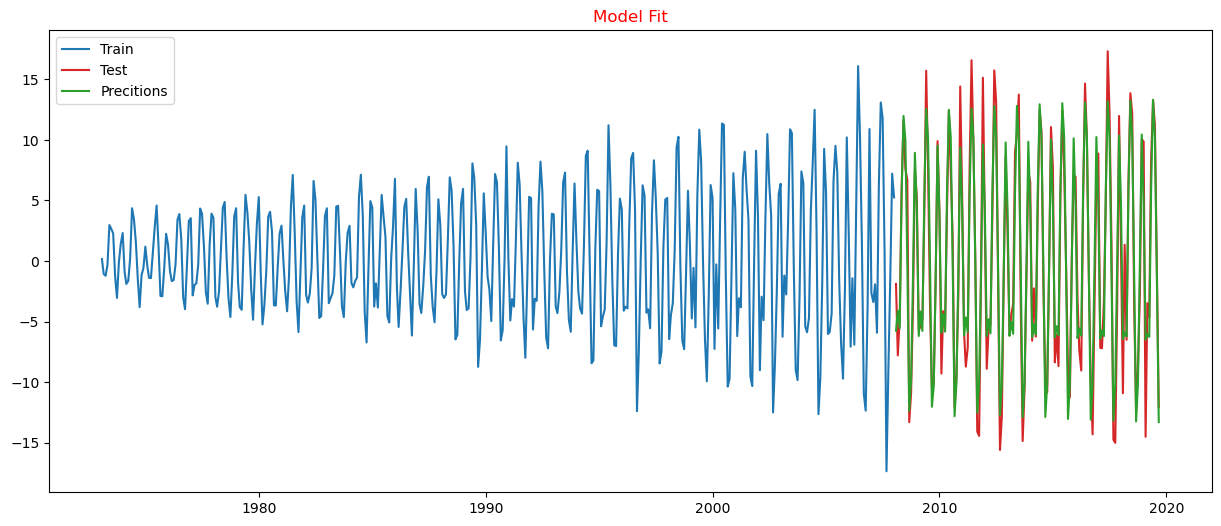

In [223]:
plt.figure(figsize=(15,6))
plt.plot(train,c='#1f77b4',label='Train')
plt.plot(test,c='#d62728',label='Test')
plt.plot(test.index, preds3,c='#2ca02c',label='Precitions')
plt.legend()
plt.title("Model Fit",c='r')
plt.show()

#### From above visualisations we can say that SARIMA is fitting in a much better way with low MAE scores.

#### Checking other evaluation metrices for SARIMA

In [224]:
mse=mean_squared_error(test,preds3)
print("RMSE :: ",np.sqrt(mse))

RMSE ::  2.4805986495176824


In [225]:
mape=mean_absolute_percentage_error(test,preds3)
print("MAPE ::",mape)

MAPE :: 0.45041638395602357


#### Based on the evaluation above, we can conclude that SARIMA is performing better than ARIMA. Therefore, we should use SARIMA for forecasting.

#### Forecasting next 2 Year data.

In [227]:
preds4 = model_fit.forecast(steps = 24)

In [230]:
preds4

2008-02-01    -5.756243
2008-03-01    -4.099392
2008-04-01    -5.544396
2008-05-01     5.434214
2008-06-01    11.989569
2008-07-01     9.996327
2008-08-01    -0.052853
2008-09-01   -12.365995
2008-10-01    -9.812939
2008-11-01    -1.220487
2008-12-01     8.941402
2009-01-01     4.375603
2009-02-01    -6.193335
2009-03-01    -4.173475
2009-04-01    -5.775996
2009-05-01     5.178421
2009-06-01    12.564374
2009-07-01    10.106967
2009-08-01     0.061668
2009-09-01   -12.043171
2009-10-01   -10.277838
2009-11-01    -1.288623
2009-12-01     9.526503
2010-01-01     3.648993
Freq: MS, Name: predicted_mean, dtype: float64